In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_density = pd.read_csv('density.csv')

In [2]:
coople = ['coople/data/coople_11072023.csv','coople/data/coople_11152023.csv','coople/data/coople_11222023.csv','coople/data/coople_11282023.csv']
misgrosi = ['misgrosi/data/misgrosi_job1108.csv','misgrosi/data/misgrosi_job1115.csv','misgrosi/data/misgrosi_job1122.csv','misgrosi/data/misgrosi_job1129.csv']
misgrosi_worker = ['misgrosi/data/misgrosi1108.csv','misgrosi/data/misgrosi1115.csv','misgrosi/data/misgrosi1122.csv','misgrosi/data/misgrosi1129.csv']
zipfel = ['zipfel/data/zipfel_zapf1108.csv','zipfel/data/zipfel_zapf1115.csv','zipfel/data/zipfel_zapf1122.csv','zipfel/data/zipfel_zapf1129.csv']

In [3]:
# Turn a list of csv str to a list of dataframe
def csv_to_df(csv):
    l = []
    for c in csv:
        df = pd.read_csv(c)
        l.append(df)
    return l

# Compare two dataframe and return the record that is in df2 but not df1, that is new record
def new(df1, df2):
    df_new = df2[~df2.isin(df1)].dropna()
    return df_new

# Compare two dataframe and return the record that is in df1 but not df2, that is deleted record
def delete(df1, df2):
    df_deleted = df1[~df1.isin(df2)].dropna()
    return df_deleted

In [4]:
def add_to_overview(platform, tp, d):
    df_list = csv_to_df(platform)
    d['Platform'].append(tp)
    for i in range(4):
        week = 'Week '+str(i+1)
        if week in d:
            d[week].append(df_list[i].shape[0])
        else:
            d[week] = [df_list[i].shape[0]]
    return d
d = add_to_overview(coople,'Coople gig',{'Platform':[]})
d = add_to_overview(misgrosi,'Misgrosi Gig',d)
d = add_to_overview(misgrosi_worker,'Misgrosi Worker',d)
d = add_to_overview(zipfel,'Zipfel Zapfl gig',d)
df = pd.DataFrame(d)
df = df.set_index('Platform')
display(df)

,Week 1,Week 2,Week 3,Week 4
Platform,,,,
Coople gig,889,760,892,920
Misgrosi gig,1169,1171,1169,1178
Misgrosi worker,103,97,103,103
Zipfel Zapfl gig,46,49,51,52


In [5]:
def groupby_post_add_urban(df):
    # Urban data group by post code
    df_count = df.groupby(['Post Code']).size().reset_index(name = 'Counts')
    
    # Merge grouped aby data with density.csv
    df = df_count.merge(df_density,on = 'Post Code',how = 'left')
    df['gig_per'] = 100*df['Counts']/df['Population']
    df = df.dropna(subset = ['Density','Population'])
    
    # Define urban column
    df['urban'] = 'unknown'
    df.loc[df['Density']<400, 'urban'] = 'rural'
    df.loc[(df['Density']>=400) & (df['Density']<1500), 'urban'] = 'urban'
    df.loc[df['Density']>1500, 'urban'] = 'urban center'
    df = df.rename(columns={'Counts': 'gig_num'})
    return df,df_count

def center_urban_rural(df):
    urban = df[df["urban"]=='urban']['gig_per']
    urban_center = df[df["urban"]=='urban center']['gig_per']
    rural = df[df["urban"]=='rural']['gig_per']
    return [urban_center, urban, rural]

In [6]:
def new_delete(data):
    # List of new data and deleted data for one platform
    new_data_list, delete_data_list = [],[]
    for i in range(3):
        df_new = new(data[i],data[i+1])
        df_delete = delete(data[i],data[i+1])
        new_data_list.append(df_new)
        delete_data_list.append(df_delete)
    
    # List of data after grouping by post code and categorizing rural and urban
    new_data_urban = [groupby_post_add_urban(df)[0] for df in new_data_list]
    delete_data_urban = [groupby_post_add_urban(df)[0] for df in delete_data_list]
    new_three = [center_urban_rural(df) for df in new_data_urban]
    delete_three = [center_urban_rural(df) for df in delete_data_urban]
    return new_data_urban, delete_data_urban, new_three, delete_three

def plot_hist(new_three,delete_three):
    # Plot three histgrams
    fig, ax = plt.subplots(2, 3, figsize=(25,14))
    for i in range(3):
        ax[0,i].hist(new_three[i], bins=20, label =['urban center','urban','rural'])
        ax[0,i].legend()
        ax[0,i].set_xlabel(f'percentage of new gig')
        ax[0,i].set_title('NEW '+' vs. '.join(['urban center','urban','rural'])+' histogram'+' WEEK '+str(i+1))
    for i in range(3):
        ax[1,i].hist(delete_three[i], bins=20, label =['urban center','urban','rural'])
        ax[1,i].legend()
        ax[1,i].set_xlabel('percentage of deleted gig')
        ax[1,i].set_title('DELETED '+' vs. '.join(['urban center','urban','rural'])+' histogram'+' WEEK '+str(i+1))
    fig.suptitle('Percentage of New and Deleted Histogram')
    plt.show()

from scipy import stats    
def density_per_scatter(data_list,col1,col2, type):
    fig, ax = plt.subplots(1, 3, figsize=(25,6))
    for i in range(3):
        df = data_list[i]
        ax[i].scatter(x=df[col1],y=df[col2])
        ax[i].set_xlabel(col1)
        ax[i].set_ylabel(col2)
        ax[i].set_title(f'WEEK {i+1} pearson r:{stats.pearsonr(df[col1], df[col2])[0]}')
        
    fig.suptitle(f'{type} and Density Scatter Plot')
    plt.show()

# Dataframe after adding post code with 0 gig percentage
def add_zero_gig(df_count):
    df_count = df_density.merge(df_count,on = 'Post Code', how = 'left')
    df_count['Counts'] = df_count['Counts'].fillna(0)
    df_count = df_count.drop(['City','Region'],axis=1)
    df_count = df_count.dropna(subset = ['Density','Population'])
    df_count['gig_per'] = 100*df_count['Counts']/df_count['Population']
    df_count = df_count.rename(columns={'Counts': 'gig_num'})
    return df_count

In [7]:
def platform_hist_corr(csv):
    data = csv_to_df(csv)
    new_data_list, delete_data_list, new_three, delete_three = new_delete(data)
    plot_hist(new_three, delete_three)
    try:
        density_per_scatter(new_data_list,'Density','gig_per', 'NEW Gig Percentage')
        density_per_scatter(delete_data_list,'Density','gig_per', 'DELETED Gig Percentage')

        new_temp = [groupby_post_add_urban(df)[1] for df in new_data_list]
        new_count_list = [add_zero_gig(df) for df in new_temp]
        delete_temp = [groupby_post_add_urban(df)[1] for df in delete_data_list]
        delete_count_list = [add_zero_gig(df) for df in delete_temp]
        density_per_scatter(new_count_list,'Density','gig_per', 'NEW Gig Percentage')
        density_per_scatter(delete_count_list,'Density','gig_per', 'DELETED Gig Percentage')
    except:
        print('No correlation plot available')


In [8]:
def summary(platform, name):
    index = ['Week 1','Week 2','Week 3']
    data = [pd.read_csv(c) for c in platform]
    new_data_list, delete_data_list =[],[]
    for i in range(3):
        new_data_list.append(new(data[i],data[i+1]))
        delete_data_list.append(delete(data[i],data[i+1]))
    new_num = [df.shape[0] for df in new_data_list]
    delete_num = [df.shape[0] for df in delete_data_list]
    
    df = pd.DataFrame({'New': new_num,'Deleted': delete_num}, index=index)
    axes = df.plot.bar(rot=0, color={"New": "blue", "Deleted": "orange"})
    plt.title(f'Number of New and Deleted Jobs for {name}')

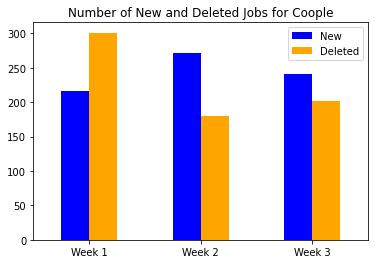

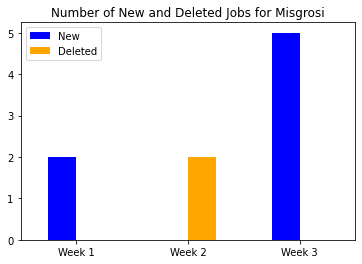

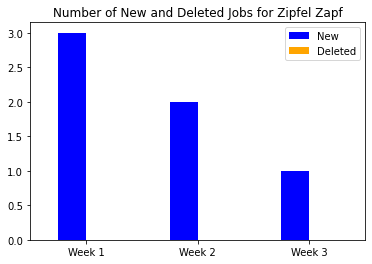

In [9]:
summary(coople,'Coople')
summary(misgrosi,'Misgrosi') 
summary(zipfel,'Zipfel Zapf')

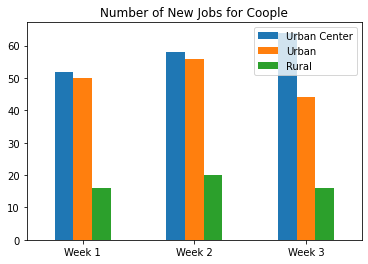

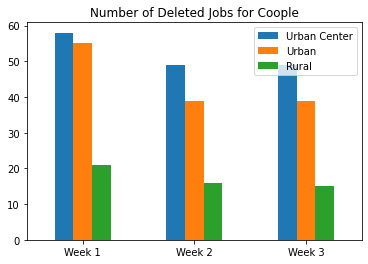

In [10]:
def summary_urban(platform, name):
    new_data_urban, delete_data_urban, new_three, delete_three = new_delete(csv_to_df(platform))
    index = ['Week 1','Week 2','Week 3']
    new_data_list, delete_data_list =[],[]
    for i in range(3):
        new_data_list.append(new_data_urban[i]['urban'].value_counts())
        delete_data_list.append(delete_data_urban[i]['urban'].value_counts())
    new_urban_center = [df.values[0] for df in new_data_list]
    new_urban = [df.values[1] for df in new_data_list]  
    new_rural = [df.values[2] for df in new_data_list] 
    delete_urban_center = [df.values[0] for df in delete_data_list]
    delete_urban = [df.values[1] for df in delete_data_list]  
    delete_rural = [df.values[2] for df in delete_data_list] 
    
    df1 = pd.DataFrame({'Urban Center': new_urban_center,'Urban': new_urban,'Rural':new_rural}, index=index)
    df1.plot.bar(rot=0)
    plt.title(f'Number of New Jobs for {name}')
    df2 = pd.DataFrame({'Urban Center': delete_urban_center,'Urban': delete_urban,'Rural':delete_rural}, index=index)
    df2.plot.bar(rot=0)
    plt.title(f'Number of Deleted Jobs for {name}')
summary_urban(coople,'Coople')

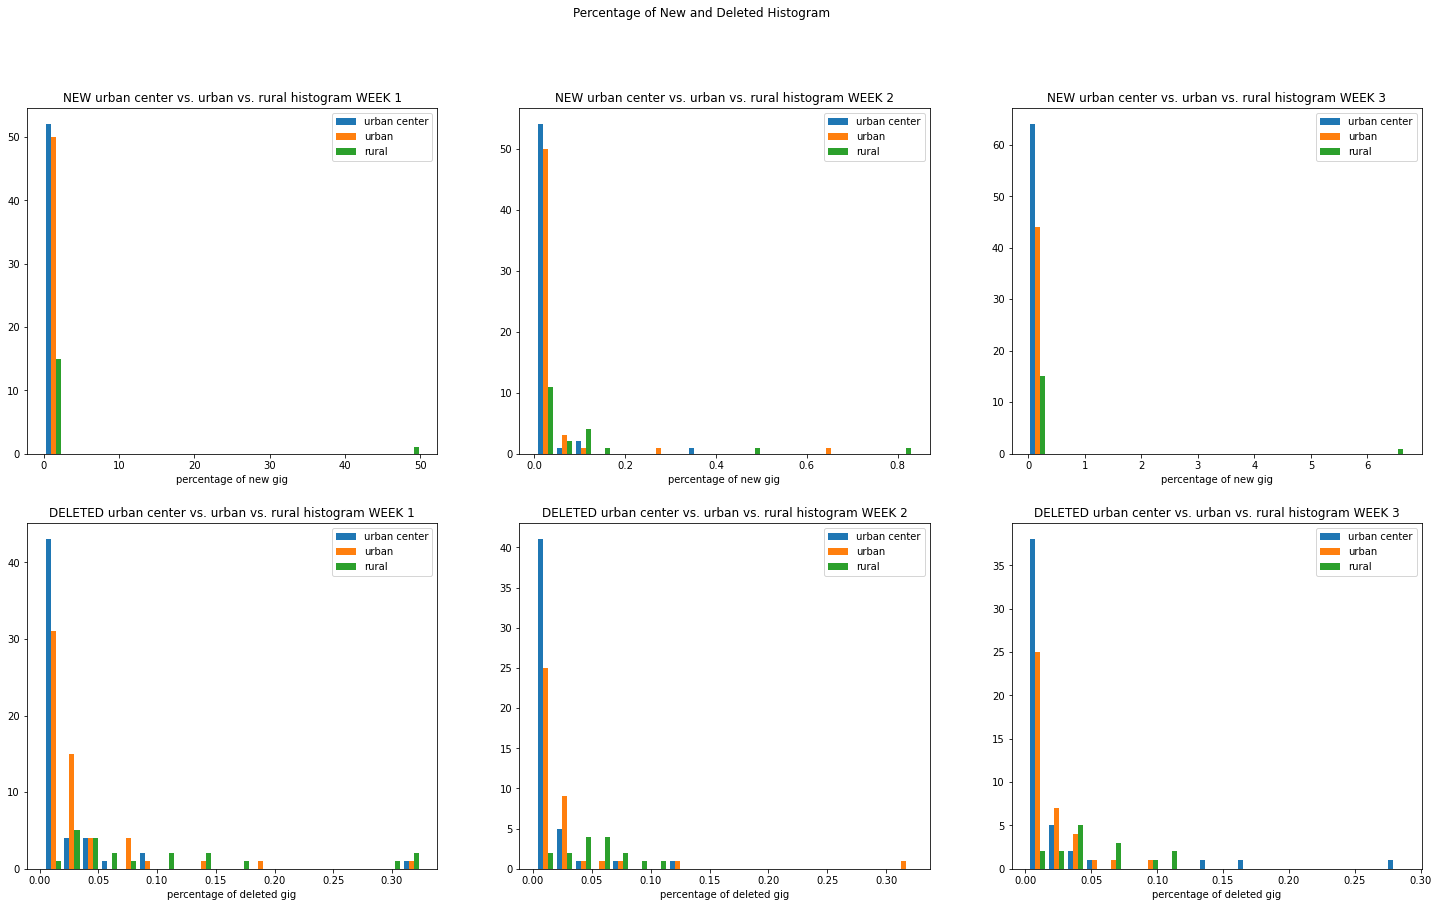

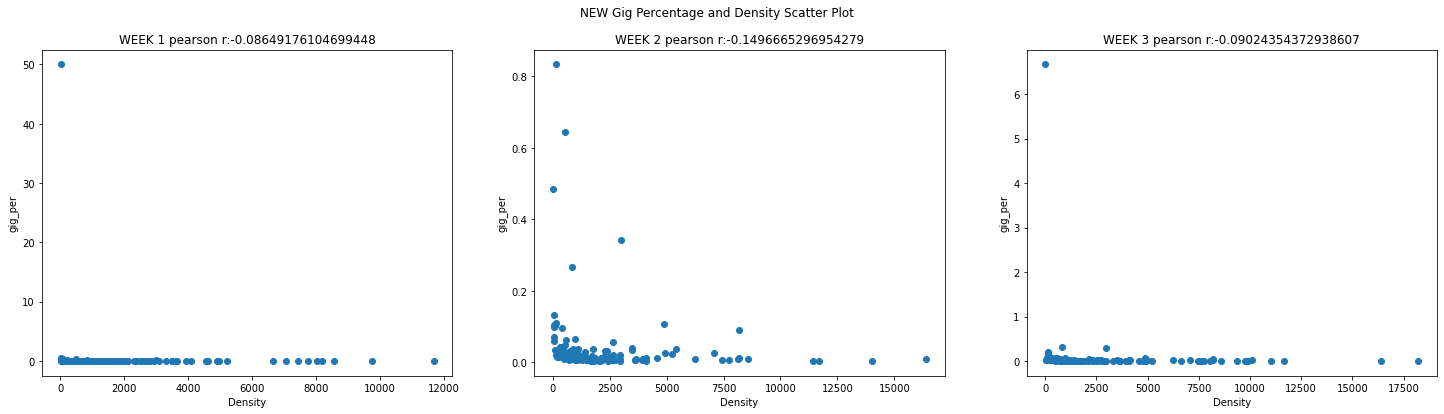

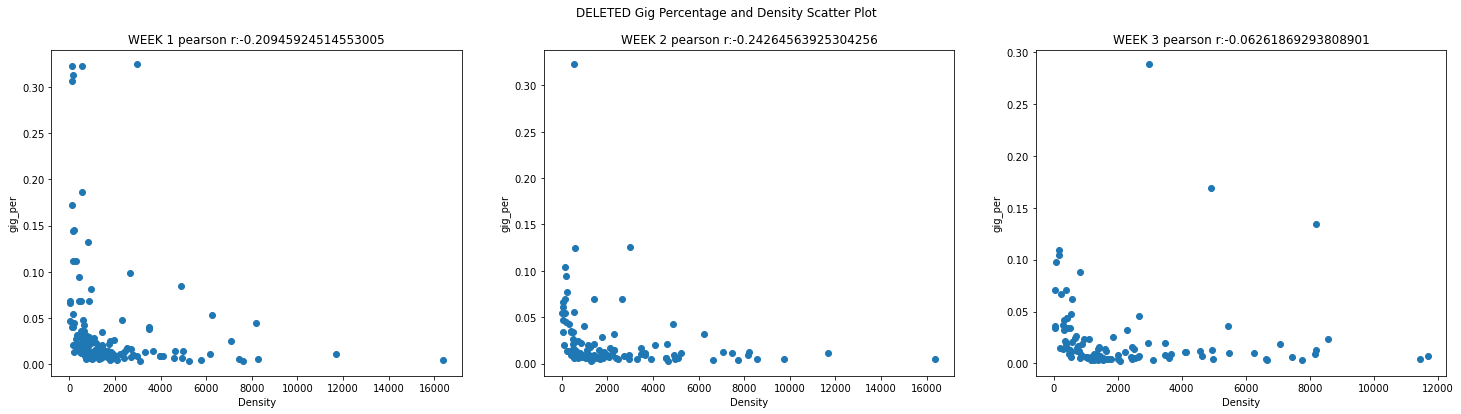

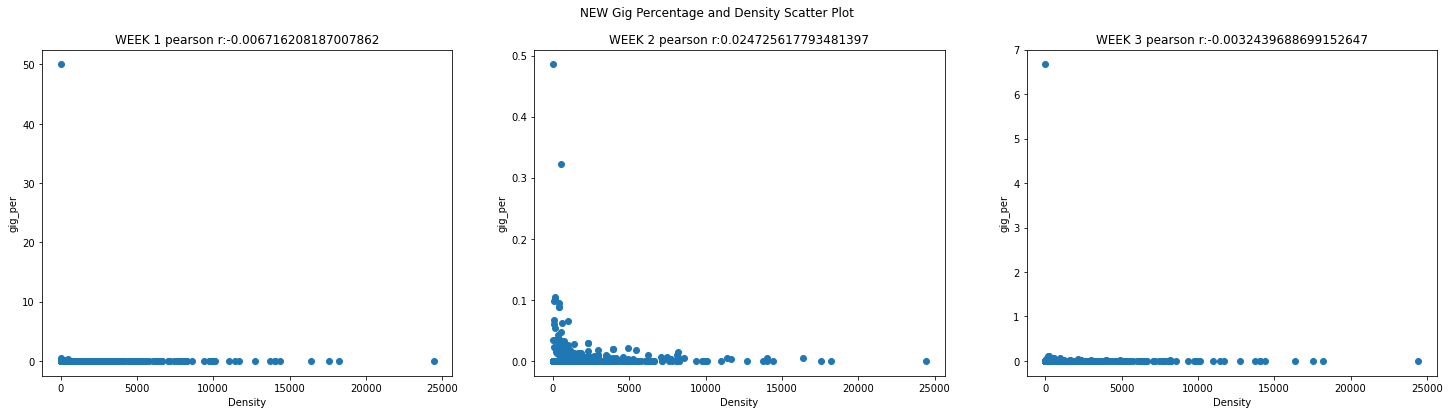

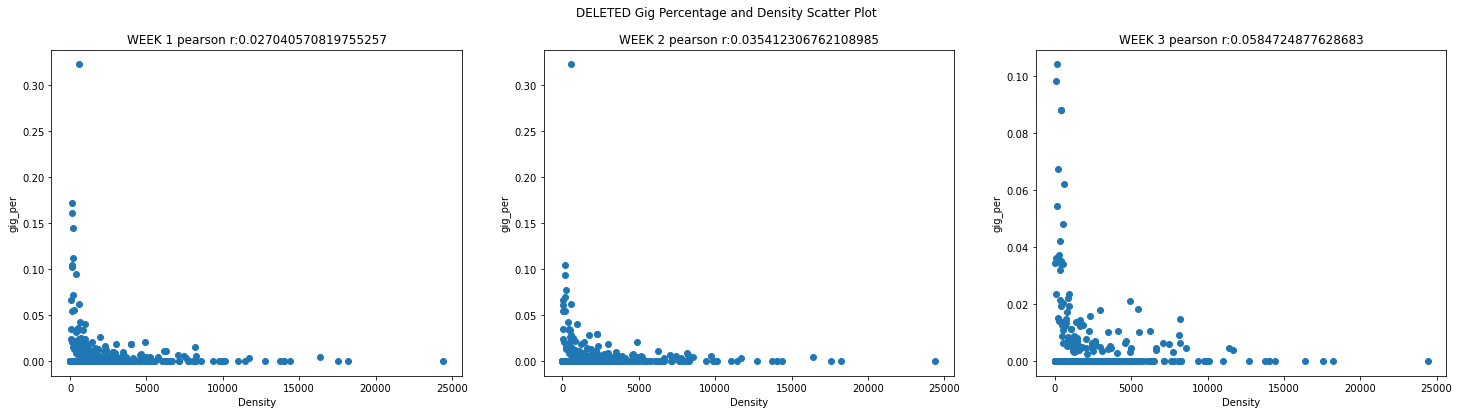

In [11]:
platform_hist_corr(coople)

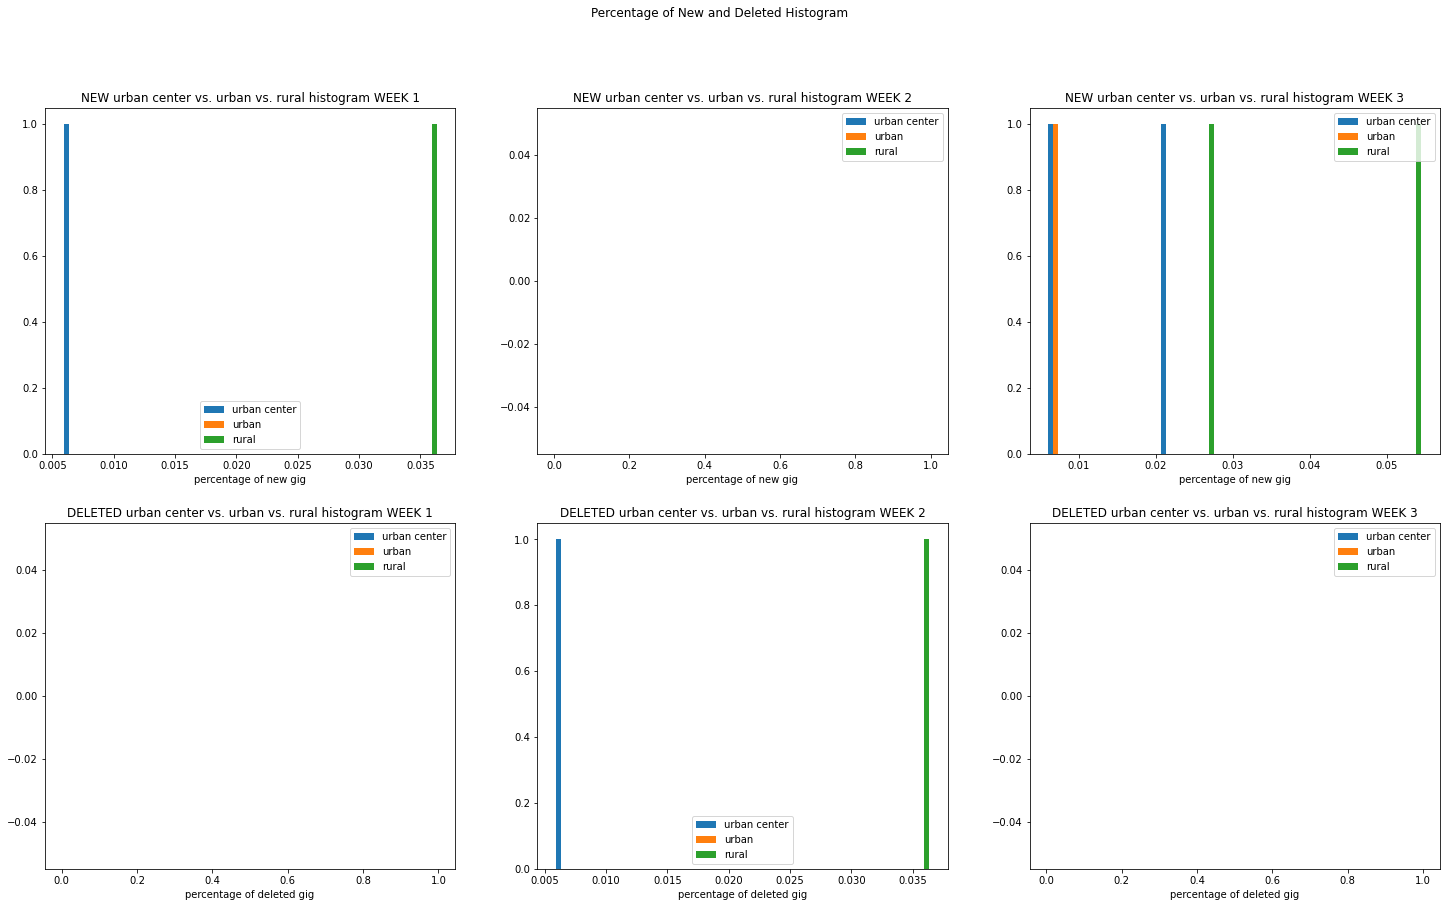

No correlation plot available


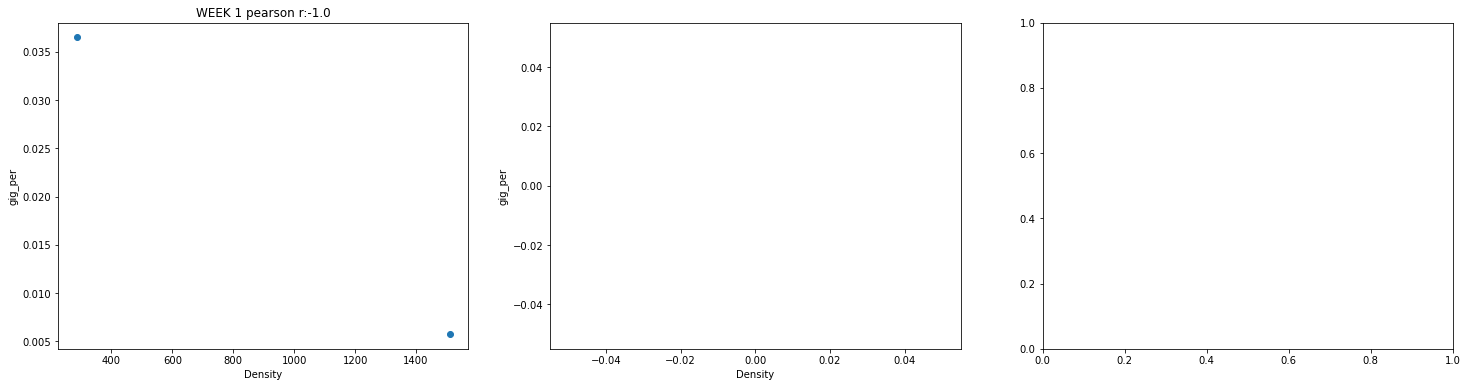

In [12]:
platform_hist_corr(misgrosi)

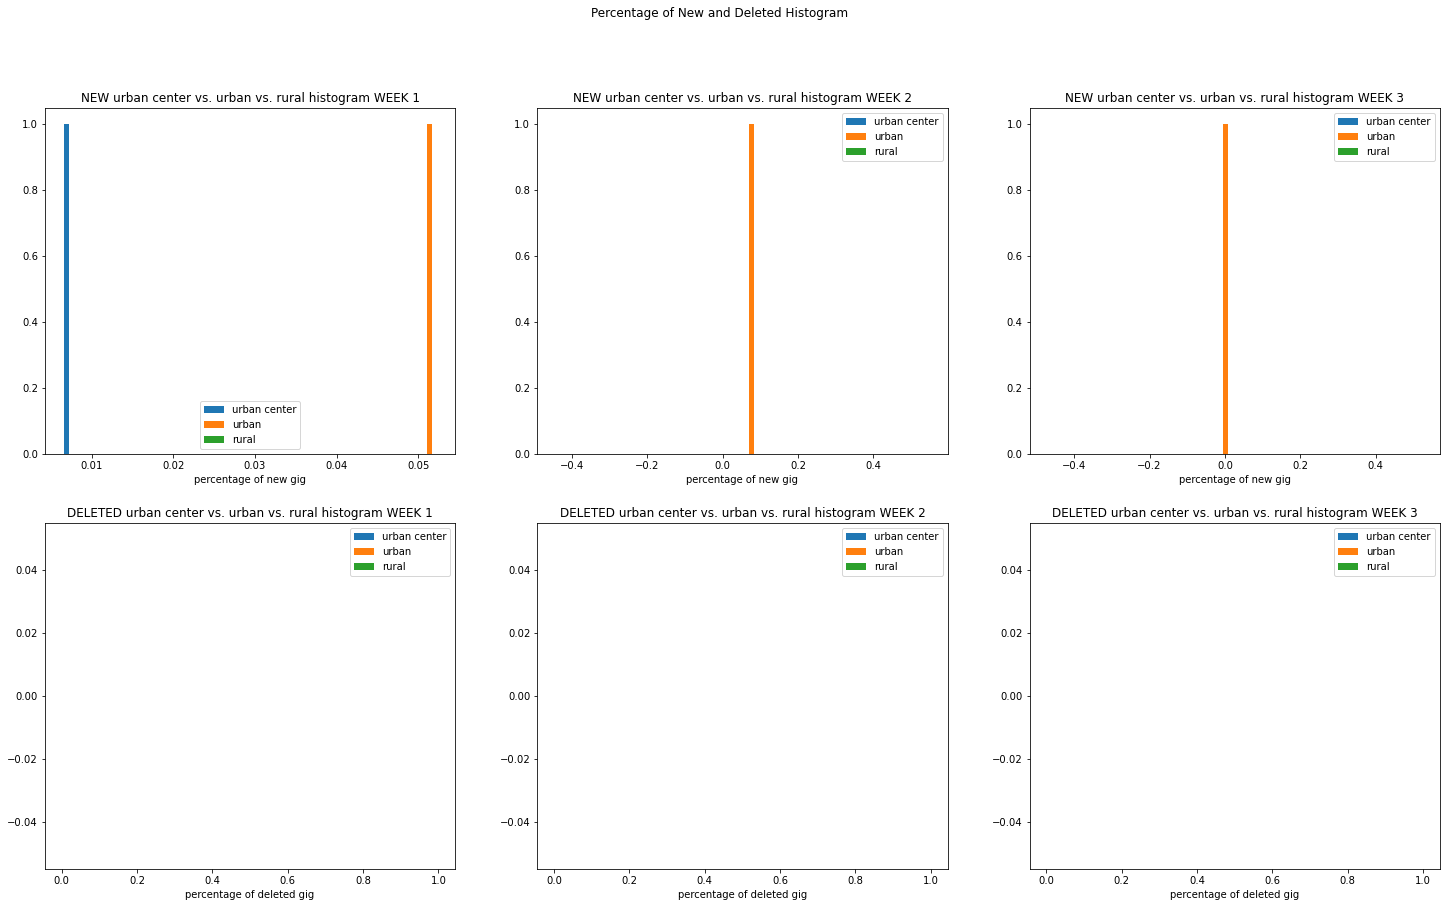

No correlation plot available


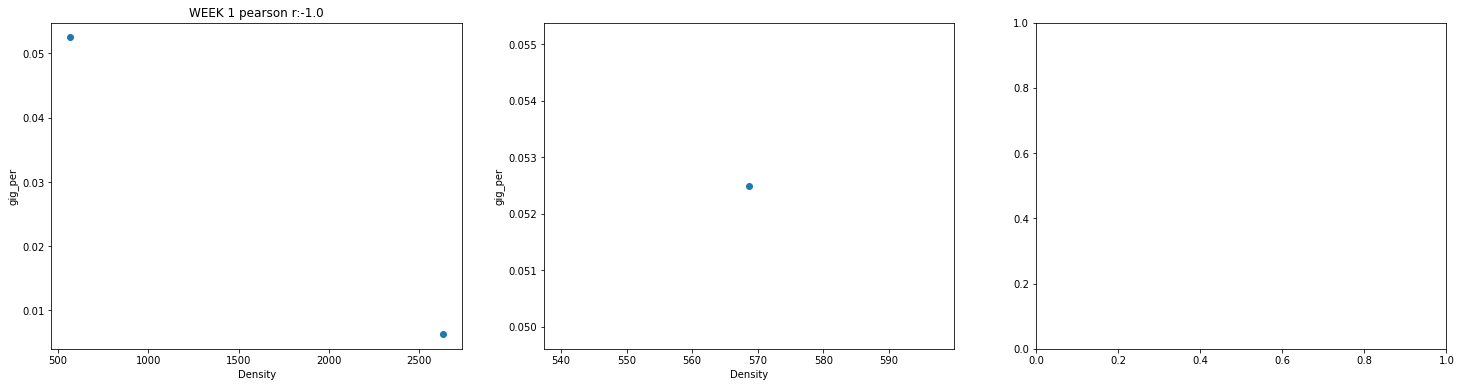

In [13]:
platform_hist_corr(zipfel)